# Loading libraries

In [338]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
from scipy.stats import mannwhitneyu, bootstrap, shapiro
import warnings
warnings.filterwarnings('ignore')


# 1. EDA

### 1.1. Loading Data

In [339]:
df = pd.read_csv('toolwindow_data.csv')
print(f"Data loaded successfully: {len(df)} rows")
df

Data loaded successfully: 3503 rows


,timestamp,event,open_type,user_id
0,1752250204033,opened,manual,1
1,1751836141616,closed,NaN,2
2,1752304475081,closed,NaN,3
3,1752498934494,opened,auto,4
4,1752141991110,closed,NaN,5
...,...,...,...,...
3498,1752370291754,closed,NaN,64
3499,1752659734021,opened,auto,43
3500,1752893558172,opened,auto,75
3501,1753022042357,opened,manual,88


### 1.2. Data Structure

In [340]:
print("Column names and types:")
print(df.dtypes)

print("First 10 rows:")
print(df.head(10))

print("Last 10 rows:")
print(df.tail(10))

print("Dataset shape:", df.shape)
print(f"  - Rows: {df.shape[0]:,}")
print(f"  - Columns: {df.shape[1]}")


Column names and types:
timestamp     int64
event        object
open_type    object
user_id       int64
dtype: object
First 10 rows:
       timestamp   event open_type  user_id
0  1752250204033  opened    manual        1
1  1751836141616  closed       NaN        2
2  1752304475081  closed       NaN        3
3  1752498934494  opened      auto        4
4  1752141991110  closed       NaN        5
5  1752308210458  opened      auto        3
6  1752310292657  opened      auto        3
7  1752276666919  closed       NaN        6
8  1752158089077  opened      auto        5
9  1752174540366  opened      auto        7
Last 10 rows:
          timestamp   event open_type  user_id
3493  1752174303733  closed       NaN        7
3494  1751883021756  closed       NaN       21
3495  1751903687439  opened      auto        8
3496  1751768263374  closed       NaN       46
3497  1752089918187  opened    manual       91
3498  1752370291754  closed       NaN       64
3499  1752659734021  opened      auto   

### 1.3. Data quality checks

In [341]:
print("Missing values per column:")
missing_counts = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Percentage': missing_pct.round(2)
})
print(missing_df)


Missing values per column:
           Missing Count  Percentage
timestamp              0        0.00
event                  0        0.00
open_type           1638       46.76
user_id                0        0.00


In [342]:
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates} ({(duplicates/len(df)*100):.2f}%)")


Duplicate rows: 0 (0.00%)


In [343]:
print("Unique values per column:")
for col in df.columns:
    unique_count = df[col].nunique()
    print(f"  - {col}: {unique_count:,} unique values")

Unique values per column:
  - timestamp: 3,503 unique values
  - event: 2 unique values
  - open_type: 2 unique values
  - user_id: 205 unique values


### 1.4. Event type analysis

In [344]:
# Count events by type
event_counts = df['event'].value_counts()
print("Event type distribution:")
print(event_counts)
print()

# Calculate the imbalance
if 'opened' in event_counts.index and 'closed' in event_counts.index:
    opened_count = event_counts['opened']
    closed_count = event_counts['closed']
    difference = opened_count - closed_count
    print(f"Event balance:")
    print(f"  - Opened events: {opened_count:,}")
    print(f"  - Closed events: {closed_count:,}")
    print(f"  - Difference: {difference:,} ({(difference/opened_count*100):.1f}%)")

# Check for any unexpected event types
print("All unique event values:")
print(df['event'].unique())


Event type distribution:
event
opened    1865
closed    1638
Name: count, dtype: int64

Event balance:
  - Opened events: 1,865
  - Closed events: 1,638
  - Difference: 227 (12.2%)
All unique event values:
['opened' 'closed']


### 1.5. Open type analysis

In [345]:
# Filter for opened events only
opened_events = df[df['event'] == 'opened'].copy()
print(f"Total opened events: {len(opened_events):,}")

# Count by open_type
open_type_counts = opened_events['open_type'].value_counts(dropna=False)
print("Open type distribution:")
print(open_type_counts)

# Calculate percentages
if len(opened_events) > 0:
    manual_count = open_type_counts.get('manual', 0)
    auto_count = open_type_counts.get('auto', 0)

    print("Open type percentages:")
    print(f"  - Manual: {manual_count:,} ({(manual_count/len(opened_events)*100):.1f}%)")
    print(f"  - Auto: {auto_count:,} ({(auto_count/len(opened_events)*100):.1f}%)")

# Check if closed events have open_type (they shouldn't)
closed_events = df[df['event'] == 'closed']
closed_with_type = closed_events['open_type'].notna().sum()
print(f"Closed events with open_type: {closed_with_type}")


Total opened events: 1,865
Open type distribution:
open_type
auto      1204
manual     661
Name: count, dtype: int64
Open type percentages:
  - Manual: 661 (35.4%)
  - Auto: 1,204 (64.6%)
Closed events with open_type: 0


### 1.6. User analysis

In [346]:
# Unique users
unique_users = df['user_id'].nunique()
print(f"Unique users: {unique_users:,}")
print()

# Events per user
events_per_user = df.groupby('user_id').size()
print("Events per user statistics:")
print(events_per_user.describe())
print()

# Users with most events
print("Top 10 users by event count:")
top_users = events_per_user.nlargest(10)
print(top_users)
print()

# Distribution of events across users
print("Distribution of events per user:")
bins = [0, 5, 10, 20, 50, 100, 500]
user_event_dist = pd.cut(events_per_user, bins=bins).value_counts().sort_index()
print(user_event_dist)
print()

Unique users: 205

Events per user statistics:
count    205.000000
mean      17.087805
std       28.556138
min        1.000000
25%        3.000000
50%        7.000000
75%       16.000000
max      188.000000
dtype: float64

Top 10 users by event count:
user_id
15    188
12    162
10    160
25    137
28    126
22    123
43    104
17     87
89     78
37     59
dtype: int64

Distribution of events per user:
(0, 5]        84
(5, 10]       48
(10, 20]      31
(20, 50]      26
(50, 100]      9
(100, 500]     7
Name: count, dtype: int64



### 1.7. Timestamp analysis

In [347]:
# Convert timestamp to datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')

# Date range
min_date = df['datetime'].min()
max_date = df['datetime'].max()
date_range = (max_date - min_date).days

print(f"Date range:")
print(f"  - Start: {min_date}")
print(f"  - End: {max_date}")
print(f"  - Duration: {date_range} days")


# Check for timestamp sorting issues
is_sorted = df.groupby('user_id')['timestamp'].apply(
    lambda x: x.is_monotonic_increasing
).all()
print(f"All users have chronologically sorted events: {is_sorted}")
if not is_sorted:
    unsorted_users = df.groupby('user_id')['timestamp'].apply(
        lambda x: not x.is_monotonic_increasing
    ).sum()
    print(f"  - Users with unsorted events: {unsorted_users}")

# Events per day
df['date'] = df['datetime'].dt.date
events_per_day = df.groupby('date').size()
print("Events per day statistics:")
print(events_per_day.describe())


Date range:
  - Start: 2025-07-03 21:54:15.846000
  - End: 2025-07-23 23:01:03.785000
  - Duration: 20 days
All users have chronologically sorted events: False
  - Users with unsorted events: 176
Events per day statistics:
count     21.000000
mean     166.809524
std       85.608188
min        2.000000
25%      111.000000
50%      159.000000
75%      217.000000
max      325.000000
dtype: float64


### 1.8. Sample user sequences

In [348]:
# 1) user with MOST events
most_user = events_per_user.idxmax()

# 2) user CLOSEST TO MEDIAN count (returns a user_id label)
median_count = events_per_user.median()
median_user = (events_per_user - median_count).abs().idxmin()

# 3) user with LEAST events
least_user = events_per_user.idxmin()

# Build list, remove duplicates (in case the same user hits multiple categories)
sample_users = pd.Index([most_user, median_user, least_user]).unique().tolist()

for idx, user_id in enumerate(sample_users, start=1):
    # ensure dtype matches; if not, cast df['user_id'] to the index dtype:
    # df['user_id'] = df['user_id'].astype(events_per_user.index.dtype)

    user_data = df.loc[df['user_id'] == user_id].sort_values('timestamp')
    event_count = int(events_per_user.loc[user_id])

    print(f"\nSample User {idx} (user_id={user_id}, {event_count} events):")
    print(user_data[['datetime', 'event', 'open_type']].head(15))

    opens  = (user_data['event'] == 'opened').sum()
    closes = (user_data['event'] == 'closed').sum()
    print(f"  - Opens: {opens}, Closes: {closes}, Balance: {opens - closes}")



Sample User 1 (user_id=15, 188 events):
                    datetime   event open_type
2098 2025-07-07 01:51:43.887  opened      auto
2390 2025-07-07 01:51:52.343  closed       NaN
596  2025-07-07 01:51:53.344  opened    manual
1972 2025-07-07 01:52:39.477  closed       NaN
1877 2025-07-10 01:50:06.865  opened      auto
701  2025-07-10 01:50:16.778  closed       NaN
2497 2025-07-10 05:28:36.300  opened      auto
3400 2025-07-10 05:43:12.441  closed       NaN
2076 2025-07-10 05:43:20.063  opened      auto
2276 2025-07-10 05:57:59.521  closed       NaN
3090 2025-07-16 03:33:36.954  opened      auto
1988 2025-07-16 03:47:53.606  closed       NaN
3422 2025-07-16 04:58:15.617  opened      auto
3201 2025-07-16 04:58:18.116  closed       NaN
1049 2025-07-16 05:01:30.096  opened      auto
  - Opens: 94, Closes: 94, Balance: 0

Sample User 2 (user_id=18, 7 events):
                    datetime   event open_type
2400 2025-07-07 11:37:30.617  opened      auto
2575 2025-07-07 12:19:55.933  closed

### 1.9. Data quality patterns

In [349]:
# Analyze sequences per user to identify issues
def analyze_user_sequence(user_df):
    """Analyze a single user's event sequence for quality issues."""
    user_df = user_df.sort_values('timestamp')

    issues = {
        'orphaned_closes': 0,
        'duplicate_opens': 0,
        'unclosed_opens': 0,
        'valid_pairs': 0
    }

    state = None  # None = expecting open, 'opened' = expecting close

    for _, row in user_df.iterrows():
        if row['event'] == 'opened':
            if state == 'opened':
                issues['duplicate_opens'] += 1
            else:
                state = 'opened'
        elif row['event'] == 'closed':
            if state == 'opened':
                issues['valid_pairs'] += 1
                state = None
            else:
                issues['orphaned_closes'] += 1

    # Check if last event was an open
    if state == 'opened':
        issues['unclosed_opens'] = 1

    return issues

# Analyze all users
all_issues = df.groupby('user_id').apply(
    lambda x: pd.Series(analyze_user_sequence(x))
)

print("\nData quality issues across all users:")
total_issues = all_issues.sum()
print(total_issues)
print()

print("Summary:")
total_events = len(df)
print(f"  - Valid open-close pairs: {int(total_issues['valid_pairs']):,}")
print(f"  - Orphaned closes: {int(total_issues['orphaned_closes']):,}")
print(f"  - Duplicate opens: {int(total_issues['duplicate_opens']):,}")
print(f"  - Unclosed opens: {int(total_issues['unclosed_opens']):,}")
print()

# Calculate expected vs actual
expected_pairs = min(event_counts.get('opened', 0), event_counts.get('closed', 0))
actual_pairs = int(total_issues['valid_pairs'])
print(f"Expected maximum pairs: {expected_pairs:,}")
print(f"Actual valid pairs found: {actual_pairs:,}")
print(f"Data retention rate: {(actual_pairs/expected_pairs*100):.1f}%")
print()



Data quality issues across all users:
orphaned_closes      16
duplicate_opens     209
unclosed_opens       34
valid_pairs        1622
dtype: int64

Summary:
  - Valid open-close pairs: 1,622
  - Orphaned closes: 16
  - Duplicate opens: 209
  - Unclosed opens: 34

Expected maximum pairs: 1,638
Actual valid pairs found: 1,622
Data retention rate: 99.0%



### 1.10. Visualization

✓ Visualization saved as 'phase1_exploration.png'



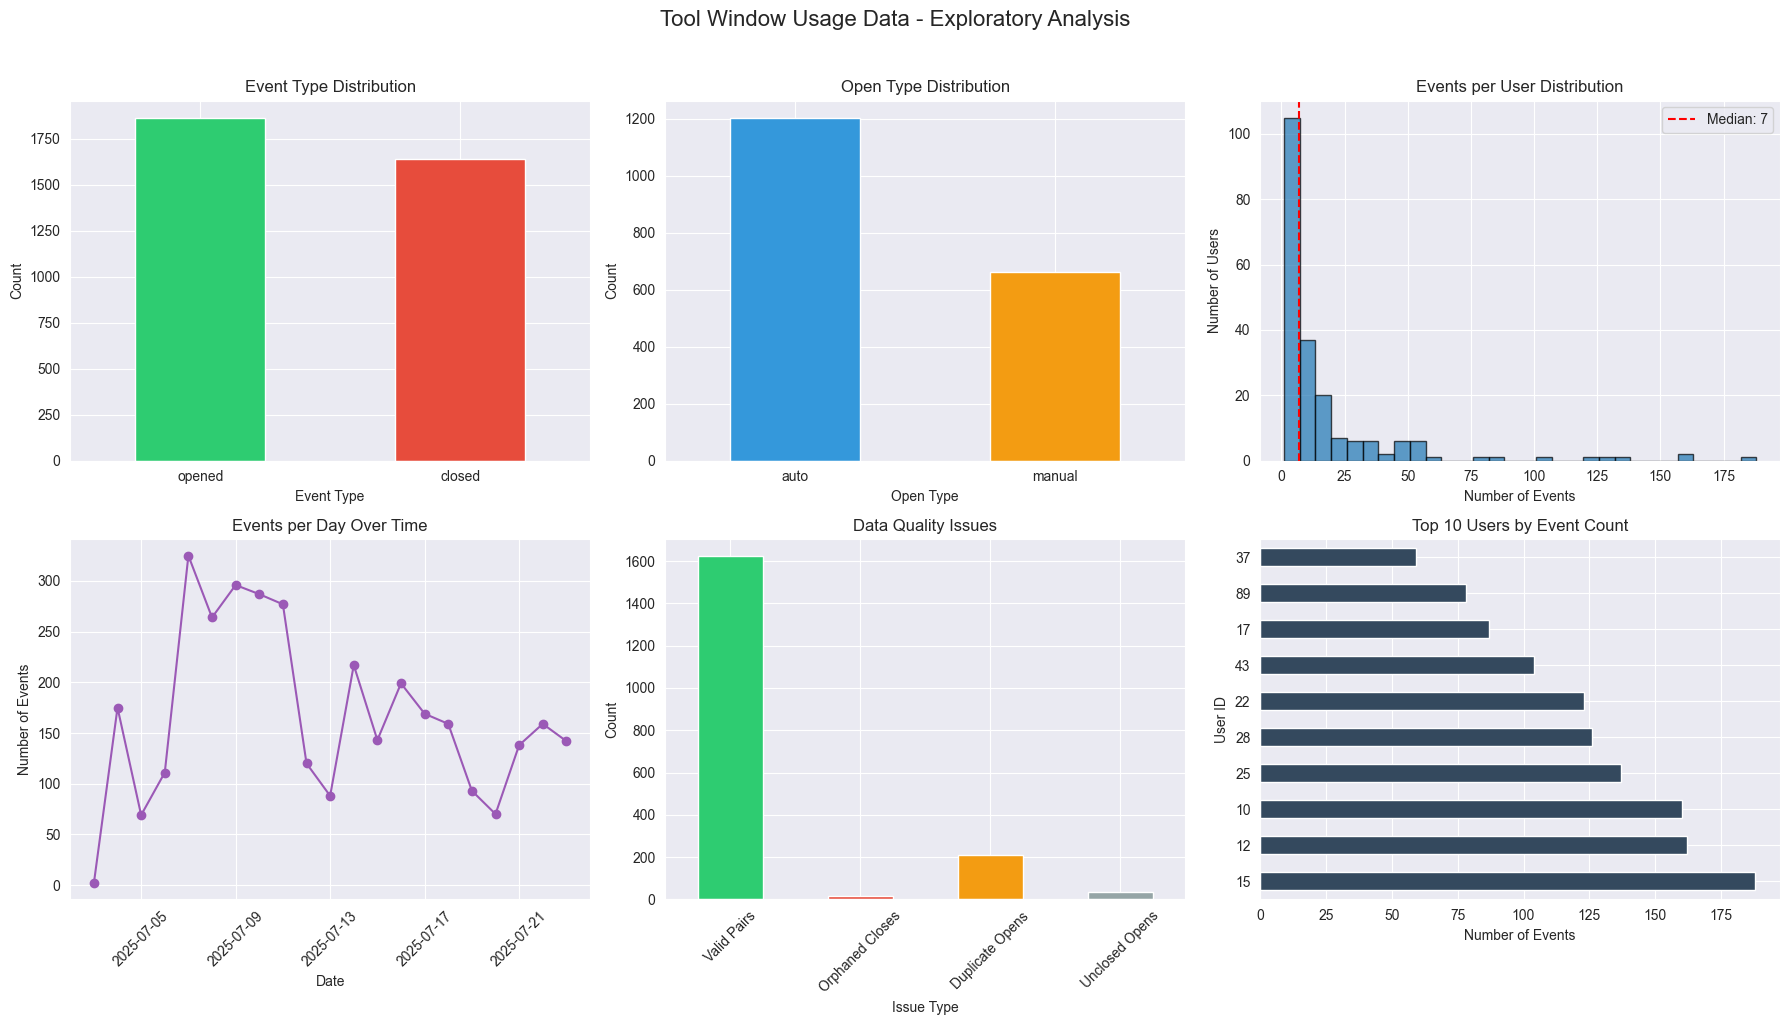

In [350]:
# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Tool Window Usage Data - Exploratory Analysis', fontsize=16, y=1.02)

# 1. Event type distribution
ax1 = axes[0, 0]
event_counts.plot(kind='bar', ax=ax1, color=['#2ecc71', '#e74c3c'])
ax1.set_title('Event Type Distribution')
ax1.set_xlabel('Event Type')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=0)

# 2. Open type distribution
ax2 = axes[0, 1]
open_type_counts.plot(kind='bar', ax=ax2, color=['#3498db', '#f39c12'])
ax2.set_title('Open Type Distribution')
ax2.set_xlabel('Open Type')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=0)

# 3. Events per user distribution
ax3 = axes[0, 2]
ax3.hist(events_per_user, bins=30, edgecolor='black', alpha=0.7)
ax3.set_title('Events per User Distribution')
ax3.set_xlabel('Number of Events')
ax3.set_ylabel('Number of Users')
ax3.axvline(events_per_user.median(), color='red', linestyle='--', label=f'Median: {events_per_user.median():.0f}')
ax3.legend()

# 4. Events over time
ax4 = axes[1, 0]
events_per_day.plot(ax=ax4, marker='o', linestyle='-', color='#9b59b6')
ax4.set_title('Events per Day Over Time')
ax4.set_xlabel('Date')
ax4.set_ylabel('Number of Events')
ax4.tick_params(axis='x', rotation=45)

# 5. Data quality issues
ax5 = axes[1, 1]
issue_data = pd.Series({
    'Valid Pairs': int(total_issues['valid_pairs']),
    'Orphaned Closes': int(total_issues['orphaned_closes']),
    'Duplicate Opens': int(total_issues['duplicate_opens']),
    'Unclosed Opens': int(total_issues['unclosed_opens'])
})
issue_data.plot(kind='bar', ax=ax5, color=['#2ecc71', '#e74c3c', '#f39c12', '#95a5a6'])
ax5.set_title('Data Quality Issues')
ax5.set_xlabel('Issue Type')
ax5.set_ylabel('Count')
ax5.tick_params(axis='x', rotation=45)

# 6. Top 10 users by events
ax6 = axes[1, 2]
top_users.plot(kind='barh', ax=ax6, color='#34495e')
ax6.set_title('Top 10 Users by Event Count')
ax6.set_xlabel('Number of Events')
ax6.set_ylabel('User ID')

plt.tight_layout()
plt.savefig('phase1_exploration.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved as 'phase1_exploration.png'")
print()

In [351]:
print(f"1. Dataset contains {len(df):,} events from {unique_users:,} users over {date_range} days")
print(f"2. Event distribution: {event_counts.get('opened', 0):,} opens, {event_counts.get('closed', 0):,} closes")
print(f"3. Open type split: {(manual_count/len(opened_events)*100):.1f}% manual, {(auto_count/len(opened_events)*100):.1f}% auto")
print(f"4. Data quality: {actual_pairs:,} valid pairs ({(actual_pairs/expected_pairs*100):.1f}% retention)")
print(f"5. Issues: {int(total_issues['orphaned_closes']):,} orphaned closes, {int(total_issues['duplicate_opens']):,} duplicate opens, {int(total_issues['unclosed_opens']):,} unclosed opens")
print()


1. Dataset contains 3,503 events from 205 users over 20 days
2. Event distribution: 1,865 opens, 1,638 closes
3. Open type split: 35.4% manual, 64.6% auto
4. Data quality: 1,622 valid pairs (99.0% retention)
5. Issues: 16 orphaned closes, 209 duplicate opens, 34 unclosed opens



# 2. Data cleaning and preprocessing

### Configuration

In [352]:
CONFIG = {
    'min_duration_sec': 0.5,        # Minimum realistic duration
    'max_duration_sec': 172800,     # Maximum realistic duration (48 hours)
    'censored_included': True,      # Include unclosed opens in main analysis
}

print("Configuration:")
print(f"  - Minimum duration threshold: {CONFIG['min_duration_sec']} seconds")
print(f"  - Maximum duration threshold: {CONFIG['max_duration_sec']} seconds ({CONFIG['max_duration_sec']/3600:.0f} hours)")
print(f"  - Include censored data: {CONFIG['censored_included']}")


Configuration:
  - Minimum duration threshold: 0.5 seconds
  - Maximum duration threshold: 172800 seconds (48 hours)
  - Include censored data: True


### 2.1. Data preparation

In [353]:
df = pd.read_csv('toolwindow_data.csv')
print(f" Loaded {len(df):,} events")

# Add datetime column
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')

# Sort by user and timestamp
df = df.sort_values(['user_id', 'timestamp']).reset_index(drop=True)
print(f" Data sorted by user_id and timestamp")

# Get dataset boundaries
min_timestamp = df['timestamp'].min()
max_timestamp = df['timestamp'].max()
dataset_start = df['datetime'].min()
dataset_end = df['datetime'].max()

print(f"  Dataset range: {dataset_start} to {dataset_end}")
print()

 Loaded 3,503 events
 Data sorted by user_id and timestamp
  Dataset range: 2025-07-03 21:54:15.846000 to 2025-07-23 23:01:03.785000



### 2.2. Event matching and session extraction

In [354]:
# Statistics tracking
stats = {
    'total_events': len(df),
    'opened_events': (df['event'] == 'opened').sum(),
    'closed_events': (df['event'] == 'closed').sum(),
    'valid_pairs': 0,
    'orphaned_closes': 0,
    'consecutive_opens_discarded': 0,
    'censored_opens': 0,
}

# Storage for sessions
sessions = []

# Process each user's events
for user_id, user_df in df.groupby('user_id'):
    user_df = user_df.reset_index(drop=True)

    current_open = None

    for idx, row in user_df.iterrows():

        if row['event'] == 'opened':
            if current_open is None:
                # Valid new open
                current_open = {
                    'user_id': user_id,
                    'open_timestamp': row['timestamp'],
                    'open_datetime': row['datetime'],
                    'open_type': row['open_type'],
                }
            else:
                # Consecutive open - discard this one, keep the first
                stats['consecutive_opens_discarded'] += 1

        elif row['event'] == 'closed':
            if current_open is not None:
                # Valid pair found
                duration_ms = row['timestamp'] - current_open['open_timestamp']
                duration_sec = duration_ms / 1000

                session = {
                    'user_id': user_id,
                    'open_type': current_open['open_type'],
                    'open_timestamp': current_open['open_timestamp'],
                    'close_timestamp': row['timestamp'],
                    'open_datetime': current_open['open_datetime'],
                    'close_datetime': row['datetime'],
                    'duration_ms': duration_ms,
                    'duration_sec': duration_sec,
                    'duration_min': duration_sec / 60,
                    'duration_hour': duration_sec / 3600,
                    'is_censored': False,
                }

                sessions.append(session)
                stats['valid_pairs'] += 1
                current_open = None
            else:
                # Orphaned close
                stats['orphaned_closes'] += 1

    # Handle unclosed opens at end of user's sequence
    if current_open is not None:
        # Calculate duration to end of dataset
        duration_ms = max_timestamp - current_open['open_timestamp']
        duration_sec = duration_ms / 1000

        session = {
            'user_id': user_id,
            'open_type': current_open['open_type'],
            'open_timestamp': current_open['open_timestamp'],
            'close_timestamp': max_timestamp,
            'open_datetime': current_open['open_datetime'],
            'close_datetime': dataset_end,
            'duration_ms': duration_ms,
            'duration_sec': duration_sec,
            'duration_min': duration_sec / 60,
            'duration_hour': duration_sec / 3600,
            'is_censored': True,
        }

        sessions.append(session)
        stats['censored_opens'] += 1

# Convert to DataFrame
sessions_df = pd.DataFrame(sessions)

print(f" Event matching complete")
print()

print("Matching Statistics:")
print(f"  Total events processed:        {stats['total_events']:,}")
print(f"  Total 'opened' events:         {stats['opened_events']:,}")
print(f"  Total 'closed' events:         {stats['closed_events']:,}")
print()
print(f"  Valid open-close pairs:        {stats['valid_pairs']:,}")
print(f"  Orphaned closes (discarded):   {stats['orphaned_closes']:,}")
print(f"  Consecutive opens (discarded): {stats['consecutive_opens_discarded']:,}")
print(f"  Censored opens (unclosed):     {stats['censored_opens']:,}")
print()

total_sessions = len(sessions_df)
retention_rate = (total_sessions / stats['opened_events']) * 100
print(f"  Total sessions created:        {total_sessions:,}")
print(f"  Data retention rate:           {retention_rate:.1f}%")
print()

 Event matching complete

Matching Statistics:
  Total events processed:        3,503
  Total 'opened' events:         1,865
  Total 'closed' events:         1,638

  Valid open-close pairs:        1,622
  Orphaned closes (discarded):   16
  Consecutive opens (discarded): 209
  Censored opens (unclosed):     34

  Total sessions created:        1,656
  Data retention rate:           88.8%



### 2.3. Data quality checks

In [355]:
# Check for negative durations (should not happen)
negative_durations = (sessions_df['duration_sec'] < 0).sum()
print(f"Negative durations found: {negative_durations}")
if negative_durations > 0:
    print("  WARNING: Negative durations detected - timestamp ordering issue!")
print()

# Check for zero durations
zero_durations = (sessions_df['duration_sec'] == 0).sum()
print(f"Zero durations found: {zero_durations} ({zero_durations/len(sessions_df)*100:.1f}%)")
print()

# Duration distribution overview
print("Duration statistics (all sessions):")
print(sessions_df['duration_sec'].describe())
print()

# Very short durations
very_short = (sessions_df['duration_sec'] < CONFIG['min_duration_sec']).sum()
print(f"Very short durations (<{CONFIG['min_duration_sec']}s): {very_short} ({very_short/len(sessions_df)*100:.1f}%)")
print()

# Very long durations
very_long = (sessions_df['duration_sec'] > CONFIG['max_duration_sec']).sum()
print(f"Very long durations (>{CONFIG['max_duration_sec']/3600:.0f}h): {very_long} ({very_long/len(sessions_df)*100:.1f}%)")
print()

Negative durations found: 0

Zero durations found: 0 (0.0%)

Duration statistics (all sessions):
count    1.656000e+03
mean     2.954533e+04
std      1.630044e+05
min      1.500000e-02
25%      1.147125e+01
50%      1.128735e+02
75%      9.234665e+02
max      1.714940e+06
Name: duration_sec, dtype: float64

Very short durations (<0.5s): 17 (1.0%)

Very long durations (>48h): 56 (3.4%)



### 2.4. Flag outliers

In [356]:
# Flag sessions based on quality criteria
sessions_df['is_outlier_short'] = sessions_df['duration_sec'] < CONFIG['min_duration_sec']
sessions_df['is_outlier_long'] = sessions_df['duration_sec'] > CONFIG['max_duration_sec']
sessions_df['is_outlier'] = sessions_df['is_outlier_short'] | sessions_df['is_outlier_long']

outlier_counts = sessions_df['is_outlier'].sum()
print(f"Total outliers flagged: {outlier_counts:,} ({outlier_counts/len(sessions_df)*100:.1f}%)")
print(f"  - Too short: {sessions_df['is_outlier_short'].sum():,}")
print(f"  - Too long: {sessions_df['is_outlier_long'].sum():,}")
print()

Total outliers flagged: 73 (4.4%)
  - Too short: 17
  - Too long: 56



### 2.5. Creating analysis datasets

In [357]:
# Dataset 1: All sessions (including censored)
sessions_all = sessions_df.copy()
print(f" Dataset 1 - All sessions: {len(sessions_all):,} sessions")

# Dataset 2: Complete sessions only (no censored)
sessions_complete = sessions_df[~sessions_df['is_censored']].copy()
print(f" Dataset 2 - Complete sessions only: {len(sessions_complete):,} sessions")

# Dataset 3: Clean sessions (no outliers, no censored)
sessions_clean = sessions_df[
    ~sessions_df['is_outlier'] &
    ~sessions_df['is_censored']
].copy()
print(f" Dataset 3 - Clean sessions: {len(sessions_clean):,} sessions")

# Dataset 4: All sessions without outliers (includes censored)
sessions_no_outliers = sessions_df[~sessions_df['is_outlier']].copy()
print(f" Dataset 4 - No outliers (with censored): {len(sessions_no_outliers):,} sessions")
print()


 Dataset 1 - All sessions: 1,656 sessions
 Dataset 2 - Complete sessions only: 1,622 sessions
 Dataset 3 - Clean sessions: 1,574 sessions
 Dataset 4 - No outliers (with censored): 1,583 sessions



### 2.6. Summary by open type

In [358]:
def print_type_summary(df, dataset_name):
    """Print summary statistics by open type."""
    print(f"\n{dataset_name}:")

    for open_type in ['manual', 'auto']:
        type_data = df[df['open_type'] == open_type]

        if len(type_data) > 0:
            print(f"\n{open_type.upper()} opens ({len(type_data):,} sessions):")

            # Duration statistics
            durations = type_data['duration_sec']
            print(f"  Duration (seconds):")
            print(f"    Mean:   {durations.mean():>12,.1f}")
            print(f"    Median: {durations.median():>12,.1f}")
            print(f"    Std:    {durations.std():>12,.1f}")
            print(f"    Min:    {durations.min():>12,.1f}")
            print(f"    Max:    {durations.max():>12,.1f}")

            # Percentiles
            print(f"  Percentiles:")
            print(f"    25th:   {durations.quantile(0.25):>12,.1f}s")
            print(f"    75th:   {durations.quantile(0.75):>12,.1f}s")
            print(f"    95th:   {durations.quantile(0.95):>12,.1f}s")

            # Censored data
            censored = type_data['is_censored'].sum()
            print(f"  Censored: {censored:,} ({censored/len(type_data)*100:.1f}%)")

# Print summaries for different datasets
print_type_summary(sessions_all, "ALL SESSIONS")
print_type_summary(sessions_complete, "COMPLETE SESSIONS ONLY")
print_type_summary(sessions_clean, "CLEAN SESSIONS")


ALL SESSIONS:

MANUAL opens (647 sessions):
  Duration (seconds):
    Mean:       25,608.1
    Median:         14.8
    Std:       174,134.9
    Min:             0.0
    Max:     1,714,940.0
  Percentiles:
    25th:            2.5s
    75th:          206.8s
    95th:       22,493.8s
  Censored: 13 (2.0%)

AUTO opens (1,009 sessions):
  Duration (seconds):
    Mean:       32,070.0
    Median:        223.9
    Std:       155,485.0
    Min:             0.2
    Max:     1,671,476.2
  Percentiles:
    25th:           43.0s
    75th:        1,745.7s
    95th:      104,857.7s
  Censored: 21 (2.1%)

COMPLETE SESSIONS ONLY:

MANUAL opens (634 sessions):
  Duration (seconds):
    Mean:        5,422.7
    Median:         14.0
    Std:        36,118.5
    Min:             0.0
    Max:       447,349.1
  Percentiles:
    25th:            2.3s
    75th:          168.6s
    95th:        6,980.0s
  Censored: 0 (0.0%)

AUTO opens (988 sessions):
  Duration (seconds):
    Mean:       15,555.9
    Median

### 2.7. Visualizations

Visualizations saved as 'phase2_cleaning_results.png'



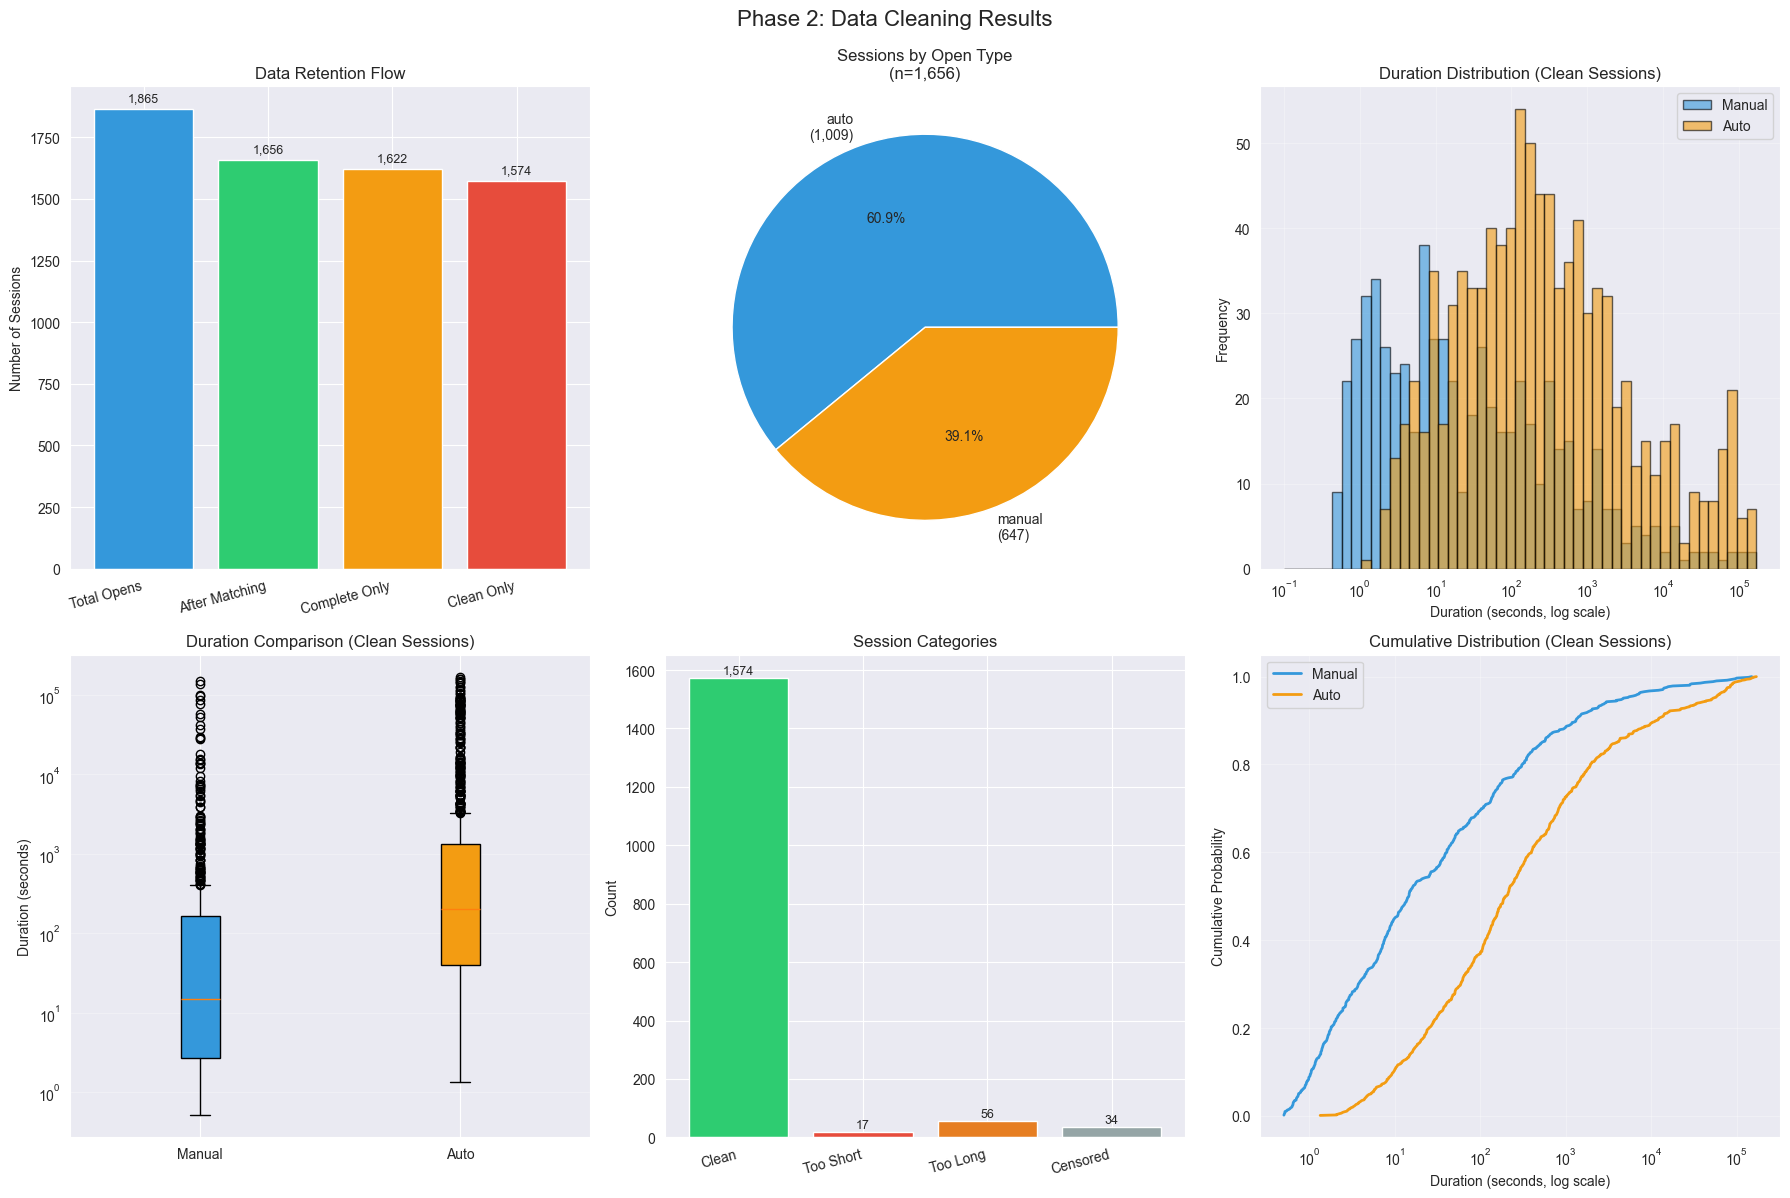

In [359]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Phase 2: Data Cleaning Results', fontsize=16, y=0.995)

# 1. Data flow diagram (bar chart showing retention)
ax1 = axes[0, 0]
flow_data = {
    'Total Opens': stats['opened_events'],
    'After Matching': stats['valid_pairs'] + stats['censored_opens'],
    'Complete Only': len(sessions_complete),
    'Clean Only': len(sessions_clean)
}
bars = ax1.bar(range(len(flow_data)), flow_data.values(),
               color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c'])
ax1.set_xticks(range(len(flow_data)))
ax1.set_xticklabels(flow_data.keys(), rotation=15, ha='right')
ax1.set_ylabel('Number of Sessions')
ax1.set_title('Data Retention Flow')
for i, (label, value) in enumerate(flow_data.items()):
    ax1.text(i, value + 20, f'{value:,}', ha='center', va='bottom', fontsize=9)

# 2. Sessions by type
ax2 = axes[0, 1]
type_counts = sessions_all['open_type'].value_counts()
ax2.pie(type_counts.values, labels=[f"{t}\n({c:,})" for t, c in zip(type_counts.index, type_counts.values)],
        autopct='%1.1f%%', colors=['#3498db', '#f39c12'])
ax2.set_title(f'Sessions by Open Type\n(n={len(sessions_all):,})')

# 3. Duration distribution (log scale)
ax3 = axes[0, 2]
manual_durations = sessions_clean[sessions_clean['open_type'] == 'manual']['duration_sec']
auto_durations = sessions_clean[sessions_clean['open_type'] == 'auto']['duration_sec']

bins = np.logspace(np.log10(0.1), np.log10(sessions_clean['duration_sec'].max()), 50)
ax3.hist(manual_durations, bins=bins, alpha=0.6, label='Manual', color='#3498db', edgecolor='black')
ax3.hist(auto_durations, bins=bins, alpha=0.6, label='Auto', color='#f39c12', edgecolor='black')
ax3.set_xscale('log')
ax3.set_xlabel('Duration (seconds, log scale)')
ax3.set_ylabel('Frequency')
ax3.set_title('Duration Distribution (Clean Sessions)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Box plot comparison
ax4 = axes[1, 0]
box_data = [
    sessions_clean[sessions_clean['open_type'] == 'manual']['duration_sec'],
    sessions_clean[sessions_clean['open_type'] == 'auto']['duration_sec']
]
bp = ax4.boxplot(box_data, labels=['Manual', 'Auto'], patch_artist=True)
bp['boxes'][0].set_facecolor('#3498db')
bp['boxes'][1].set_facecolor('#f39c12')
ax4.set_ylabel('Duration (seconds)')
ax4.set_title('Duration Comparison (Clean Sessions)')
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3, axis='y')

# 5. Outlier breakdown
ax5 = axes[1, 1]
outlier_data = {
    'Clean': len(sessions_clean),
    'Too Short': sessions_df['is_outlier_short'].sum(),
    'Too Long': sessions_df['is_outlier_long'].sum(),
    'Censored': sessions_df['is_censored'].sum()
}
colors_outlier = ['#2ecc71', '#e74c3c', '#e67e22', '#95a5a6']
ax5.bar(range(len(outlier_data)), outlier_data.values(), color=colors_outlier)
ax5.set_xticks(range(len(outlier_data)))
ax5.set_xticklabels(outlier_data.keys(), rotation=15, ha='right')
ax5.set_ylabel('Count')
ax5.set_title('Session Categories')
for i, value in enumerate(outlier_data.values()):
    ax5.text(i, value + 5, f'{value:,}', ha='center', va='bottom', fontsize=9)

# 6. Cumulative distribution function
ax6 = axes[1, 2]
manual_sorted = np.sort(sessions_clean[sessions_clean['open_type'] == 'manual']['duration_sec'])
auto_sorted = np.sort(sessions_clean[sessions_clean['open_type'] == 'auto']['duration_sec'])
manual_cdf = np.arange(1, len(manual_sorted) + 1) / len(manual_sorted)
auto_cdf = np.arange(1, len(auto_sorted) + 1) / len(auto_sorted)

ax6.plot(manual_sorted, manual_cdf, label='Manual', color='#3498db', linewidth=2)
ax6.plot(auto_sorted, auto_cdf, label='Auto', color='#f39c12', linewidth=2)
ax6.set_xscale('log')
ax6.set_xlabel('Duration (seconds, log scale)')
ax6.set_ylabel('Cumulative Probability')
ax6.set_title('Cumulative Distribution (Clean Sessions)')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('phase2_cleaning_results.png', dpi=300, bbox_inches='tight')
print("Visualizations saved as 'phase2_cleaning_results.png'")
print()

### 2.8. Export clean data

In [360]:
# Export all datasets
sessions_all.to_csv('sessions_all.csv', index=False)
print(f" Exported: sessions_all.csv ({len(sessions_all):,} sessions)")

sessions_complete.to_csv('sessions_complete.csv', index=False)
print(f" Exported: sessions_complete.csv ({len(sessions_complete):,} sessions)")

sessions_clean.to_csv('sessions_clean.csv', index=False)
print(f" Exported: sessions_clean.csv ({len(sessions_clean):,} sessions)")

sessions_no_outliers.to_csv('sessions_no_outliers.csv', index=False)
print(f" Exported: sessions_no_outliers.csv ({len(sessions_no_outliers):,} sessions)")

# Export summary statistics
summary_stats = {
    'dataset': ['all', 'complete', 'clean', 'no_outliers'],
    'total_sessions': [len(sessions_all), len(sessions_complete), len(sessions_clean), len(sessions_no_outliers)],
    'manual_sessions': [
        (sessions_all['open_type'] == 'manual').sum(),
        (sessions_complete['open_type'] == 'manual').sum(),
        (sessions_clean['open_type'] == 'manual').sum(),
        (sessions_no_outliers['open_type'] == 'manual').sum()
    ],
    'auto_sessions': [
        (sessions_all['open_type'] == 'auto').sum(),
        (sessions_complete['open_type'] == 'auto').sum(),
        (sessions_clean['open_type'] == 'auto').sum(),
        (sessions_no_outliers['open_type'] == 'auto').sum()
    ]
}
summary_df = pd.DataFrame(summary_stats)
summary_df.to_csv('cleaning_summary.csv', index=False)
print(f" Exported: cleaning_summary.csv")
print()

 Exported: sessions_all.csv (1,656 sessions)
 Exported: sessions_complete.csv (1,622 sessions)
 Exported: sessions_clean.csv (1,574 sessions)
 Exported: sessions_no_outliers.csv (1,583 sessions)
 Exported: cleaning_summary.csv



In [361]:
print("DATA CLEANING COMPLETE:")
print()
print(f"Input:  {stats['total_events']:,} raw events")
print(f"Output: {len(sessions_clean):,} clean sessions ready for analysis")
print()

print("RETENTION RATES:")
print(f"  Overall retention:  {retention_rate:.1f}%")
print(f"  Clean data rate:    {len(sessions_clean)/stats['opened_events']*100:.1f}%")
print()

print("RECOMMENDED DATASET FOR PHASE 3:")
print(f"  sessions_clean.csv ({len(sessions_clean):,} sessions)")
print(f"    - No outliers (durations between {CONFIG['min_duration_sec']}s and {CONFIG['max_duration_sec']/3600:.0f}h)")
print(f"    - No censored sessions")
print(f"    - {(sessions_clean['open_type']=='manual').sum():,} manual, {(sessions_clean['open_type']=='auto').sum():,} auto")
print()

DATA CLEANING COMPLETE:

Input:  3,503 raw events
Output: 1,574 clean sessions ready for analysis

RETENTION RATES:
  Overall retention:  88.8%
  Clean data rate:    84.4%

RECOMMENDED DATASET FOR PHASE 3:
  sessions_clean.csv (1,574 sessions)
    - No outliers (durations between 0.5s and 48h)
    - No censored sessions
    - 612 manual, 962 auto



# 3. Statistical Analysis & Hypothesis Testing

### 3.1. Loading data

In [362]:
sessions_clean = pd.read_csv('sessions_clean.csv')
print(f" Loaded clean dataset: {len(sessions_clean):,} sessions")
print()

# Separate by open type
manual_sessions = sessions_clean[sessions_clean['open_type'] == 'manual']
auto_sessions = sessions_clean[sessions_clean['open_type'] == 'auto']

print(f"Manual sessions: {len(manual_sessions):,}")
print(f"Auto sessions:   {len(auto_sessions):,}")
print()

 Loaded clean dataset: 1,574 sessions

Manual sessions: 612
Auto sessions:   962



### 3.2 Descriptive statistics

In [363]:
def calculate_stats(data, label):
    """Calculate comprehensive statistics for a dataset."""
    stats_dict = {
        'group': label,
        'n': len(data),
        'mean': data.mean(),
        'median': data.median(),
        'std': data.std(),
        'min': data.min(),
        'max': data.max(),
        'q25': data.quantile(0.25),
        'q75': data.quantile(0.75),
        'iqr': data.quantile(0.75) - data.quantile(0.25),
        'skewness': data.skew(),
        'kurtosis': data.kurtosis(),
    }
    return stats_dict

manual_stats = calculate_stats(manual_sessions['duration_sec'], 'Manual')
auto_stats = calculate_stats(auto_sessions['duration_sec'], 'Auto')

# Create comparison table
stats_df = pd.DataFrame([manual_stats, auto_stats])
stats_df = stats_df.set_index('group')

print("Duration Statistics by Open Type:")
print()
print(f"{'Metric':<20} {'Manual':>15} {'Auto':>15} {'Difference':>15}")
print("-" * 80)

metrics = [
    ('Sample Size', 'n', '{:.0f}'),
    ('Mean (sec)', 'mean', '{:,.1f}'),
    ('Median (sec)', 'median', '{:,.1f}'),
    ('Std Dev (sec)', 'std', '{:,.1f}'),
    ('Min (sec)', 'min', '{:,.1f}'),
    ('Max (sec)', 'max', '{:,.1f}'),
    ('25th %ile (sec)', 'q25', '{:,.1f}'),
    ('75th %ile (sec)', 'q75', '{:,.1f}'),
    ('IQR (sec)', 'iqr', '{:,.1f}'),
    ('Skewness', 'skewness', '{:.2f}'),
    ('Kurtosis', 'kurtosis', '{:.2f}'),
]

for label, key, fmt in metrics:
    manual_val = stats_df.loc['Manual', key]
    auto_val = stats_df.loc['Auto', key]

    if key in ['n', 'skewness', 'kurtosis']:
        diff = auto_val - manual_val
        print(f"{label:<20} {fmt.format(manual_val):>15} {fmt.format(auto_val):>15} {fmt.format(diff):>15}")
    else:
        ratio = auto_val / manual_val if manual_val != 0 else float('inf')
        print(f"{label:<20} {fmt.format(manual_val):>15} {fmt.format(auto_val):>15} {ratio:>14.1f}x")

print()

# Key observation
median_ratio = auto_stats['median'] / manual_stats['median']
mean_ratio = auto_stats['mean'] / manual_stats['mean']

print("KEY OBSERVATIONS:")
print(f"   Auto sessions have {median_ratio:.1f}x longer MEDIAN duration")
print(f"   Auto sessions have {mean_ratio:.1f}x longer MEAN duration")
print(f"   Both distributions are highly right-skewed (long tails)")
print()


Duration Statistics by Open Type:

Metric                        Manual            Auto      Difference
--------------------------------------------------------------------------------
Sample Size                      612             962             350
Mean (sec)                   2,010.8         6,449.8            3.2x
Median (sec)                    14.7           201.6           13.8x
Std Dev (sec)               11,866.7        21,060.2            1.8x
Min (sec)                        0.5             1.3            2.7x
Max (sec)                  150,501.0       170,204.2            1.1x
25th %ile (sec)                  2.7            39.2           14.7x
75th %ile (sec)                164.2         1,326.3            8.1x
IQR (sec)                      161.5         1,287.1            8.0x
Skewness                        8.90            4.48           -4.42
Kurtosis                       88.58           22.08          -66.50

KEY OBSERVATIONS:
   Auto sessions have 13.8x longer ME

### 3.3. Normality test

In [364]:
from scipy import stats  # Add this import at the top

# Shapiro-Wilk test (use sample if dataset too large)
def test_normality(data, label, max_sample=5000):
    """Test normality using Shapiro-Wilk test."""
    if len(data) > max_sample:
        sample = data.sample(max_sample, random_state=42)
        print(f"{label} (using sample of {max_sample}):")
    else:
        sample = data
        print(f"{label}:")

    stat, p_value = stats.shapiro(sample)
    print(f"  Shapiro-Wilk statistic: {stat:.4f}")
    print(f"  p-value: {p_value:.4e}")

    if p_value < 0.05:
        print(f"   Data is NOT normally distributed (p < 0.05)")
    else:
        print(f"   Data appears normally distributed (p >= 0.05)")
    print()

    return p_value

manual_p = test_normality(manual_sessions['duration_sec'], "Manual Opens")
auto_p = test_normality(auto_sessions['duration_sec'], "Auto Opens")

print("CONCLUSION:")
if manual_p < 0.05 or auto_p < 0.05:
    print("   At least one group is non-normal")
    print("   Will use NON-PARAMETRIC tests (Mann-Whitney U)")
    use_nonparametric = True
else:
    print("   Both groups appear normal")
    print("   Can use parametric tests (t-test) but will use both")
    use_nonparametric = False
print()

Manual Opens:
  Shapiro-Wilk statistic: 0.1572
  p-value: 1.0721e-45
   Data is NOT normally distributed (p < 0.05)

Auto Opens:
  Shapiro-Wilk statistic: 0.3398
  p-value: 4.9862e-50
   Data is NOT normally distributed (p < 0.05)

CONCLUSION:
   At least one group is non-normal
   Will use NON-PARAMETRIC tests (Mann-Whitney U)



### 3.4. Hypothesis testing

In [365]:
print("  Null Hypothesis: Manual and Auto opens have the same median duration")
print("  Alternative Hypothesis: Manual and Auto opens have different median durations")
print()

# Mann-Whitney U Test (non-parametric)
print("TEST 1: Mann-Whitney U Test (Wilcoxon Rank-Sum)")
print()
print("Purpose: Compare medians of two independent groups")
print("Assumptions: Independent samples, ordinal or continuous data")
print()

u_statistic, p_value_mw = mannwhitneyu(
    manual_sessions['duration_sec'],
    auto_sessions['duration_sec'],
    alternative='two-sided'
)

print(f"U-statistic: {u_statistic:,.0f}")
print(f"p-value: {p_value_mw:.4e}")
print()

alpha = 0.05
if p_value_mw < alpha:
    print(f" SIGNIFICANT DIFFERENCE (p < {alpha})")
    print("   We reject the null hypothesis")
    print("   Manual and Auto opens have statistically different median durations")
else:
    print(f" NO SIGNIFICANT DIFFERENCE (p >= {alpha})")
    print("   We fail to reject the null hypothesis")
    print("   Cannot conclude the medians are different")
print()

# Effect size (Rank-Biserial Correlation)
n1 = len(manual_sessions)
n2 = len(auto_sessions)
rank_biserial = 1 - (2*u_statistic) / (n1 * n2)

print(f"Effect Size (Rank-Biserial): {rank_biserial:.3f}")
print("Interpretation:")
if abs(rank_biserial) < 0.1:
    effect_interpretation = "negligible"
elif abs(rank_biserial) < 0.3:
    effect_interpretation = "small"
elif abs(rank_biserial) < 0.5:
    effect_interpretation = "medium"
else:
    effect_interpretation = "large"
print(f"   Effect size is {effect_interpretation}")
print()

# Independent t-test (parametric, for comparison)
print("TEST 2: Welch's t-test (for comparison)")
print()
print("Purpose: Compare means of two independent groups")
print("Note: Less appropriate for skewed data, included for completeness")
print()

t_statistic, p_value_t = stats.ttest_ind(
    manual_sessions['duration_sec'],
    auto_sessions['duration_sec'],
    equal_var=False  # Welch's t-test
)

print(f"t-statistic: {t_statistic:.4f}")
print(f"p-value: {p_value_t:.4e}")
print()

if p_value_t < alpha:
    print(f" SIGNIFICANT DIFFERENCE (p < {alpha})")
else:
    print(f" NO SIGNIFICANT DIFFERENCE (p >= {alpha})")
print()

# Cohen's d effect size
pooled_std = np.sqrt(((n1-1)*manual_stats['std']**2 + (n2-1)*auto_stats['std']**2) / (n1+n2-2))
cohens_d = (auto_stats['mean'] - manual_stats['mean']) / pooled_std

print(f"Effect Size (Cohen's d): {cohens_d:.3f}")
print("Interpretation:")
if abs(cohens_d) < 0.2:
    effect_interpretation_d = "negligible"
elif abs(cohens_d) < 0.5:
    effect_interpretation_d = "small"
elif abs(cohens_d) < 0.8:
    effect_interpretation_d = "medium"
else:
    effect_interpretation_d = "large"
print(f"   Effect size is {effect_interpretation_d}")
print()


  Null Hypothesis: Manual and Auto opens have the same median duration
  Alternative Hypothesis: Manual and Auto opens have different median durations

TEST 1: Mann-Whitney U Test (Wilcoxon Rank-Sum)

Purpose: Compare medians of two independent groups
Assumptions: Independent samples, ordinal or continuous data

U-statistic: 156,860
p-value: 3.6990e-55

 SIGNIFICANT DIFFERENCE (p < 0.05)
   We reject the null hypothesis
   Manual and Auto opens have statistically different median durations

Effect Size (Rank-Biserial): 0.467
Interpretation:
   Effect size is medium

TEST 2: Welch's t-test (for comparison)

Purpose: Compare means of two independent groups
Note: Less appropriate for skewed data, included for completeness

t-statistic: -5.3395
p-value: 1.0702e-07

 SIGNIFICANT DIFFERENCE (p < 0.05)

Effect Size (Cohen's d): 0.246
Interpretation:
   Effect size is small



### 3.5. Bootstrap CI

In [366]:
print("(10,000 bootstrap samples)")
print()

# Bootstrap for median difference
def median_diff(manual, auto):
    """Calculate difference in medians."""
    return np.median(auto) - np.median(manual)

# Prepare data
manual_data = manual_sessions['duration_sec'].values
auto_data = auto_sessions['duration_sec'].values

# Bootstrap for median
np.random.seed(42)
bootstrap_diffs_median = []
for _ in range(10000):
    manual_sample = np.random.choice(manual_data, size=len(manual_data), replace=True)
    auto_sample = np.random.choice(auto_data, size=len(auto_data), replace=True)
    diff = np.median(auto_sample) - np.median(manual_sample)
    bootstrap_diffs_median.append(diff)

median_ci_lower = np.percentile(bootstrap_diffs_median, 2.5)
median_ci_upper = np.percentile(bootstrap_diffs_median, 97.5)
median_diff_observed = np.median(auto_data) - np.median(manual_data)

print(f"Observed median difference: {median_diff_observed:,.1f} seconds")
print(f"95% CI: [{median_ci_lower:,.1f}, {median_ci_upper:,.1f}] seconds")
print()

if median_ci_lower > 0:
    print(" CI does NOT include zero -> Significant difference")
    print("   Auto opens stay open longer (with 95% confidence)")
elif median_ci_upper < 0:
    print(" CI does NOT include zero -> Significant difference")
    print("   Manual opens stay open longer (with 95% confidence)")
else:
    print(" CI includes zero -> No significant difference")
print()

# Bootstrap for mean difference
bootstrap_diffs_mean = []
for _ in range(10000):
    manual_sample = np.random.choice(manual_data, size=len(manual_data), replace=True)
    auto_sample = np.random.choice(auto_data, size=len(auto_data), replace=True)
    diff = np.mean(auto_sample) - np.mean(manual_sample)
    bootstrap_diffs_mean.append(diff)

mean_ci_lower = np.percentile(bootstrap_diffs_mean, 2.5)
mean_ci_upper = np.percentile(bootstrap_diffs_mean, 97.5)
mean_diff_observed = np.mean(auto_data) - np.mean(manual_data)

print(f"Observed mean difference: {mean_diff_observed:,.1f} seconds")
print(f"95% CI: [{mean_ci_lower:,.1f}, {mean_ci_upper:,.1f}] seconds")
print()


(10,000 bootstrap samples)

Observed median difference: 187.0 seconds
95% CI: [148.4, 232.2] seconds

 CI does NOT include zero -> Significant difference
   Auto opens stay open longer (with 95% confidence)

Observed mean difference: 4,439.0 seconds
95% CI: [2,822.7, 6,038.7] seconds



### 3.6. Visualizations

Visualization saved as 'phase3_statistical_analysis.png'



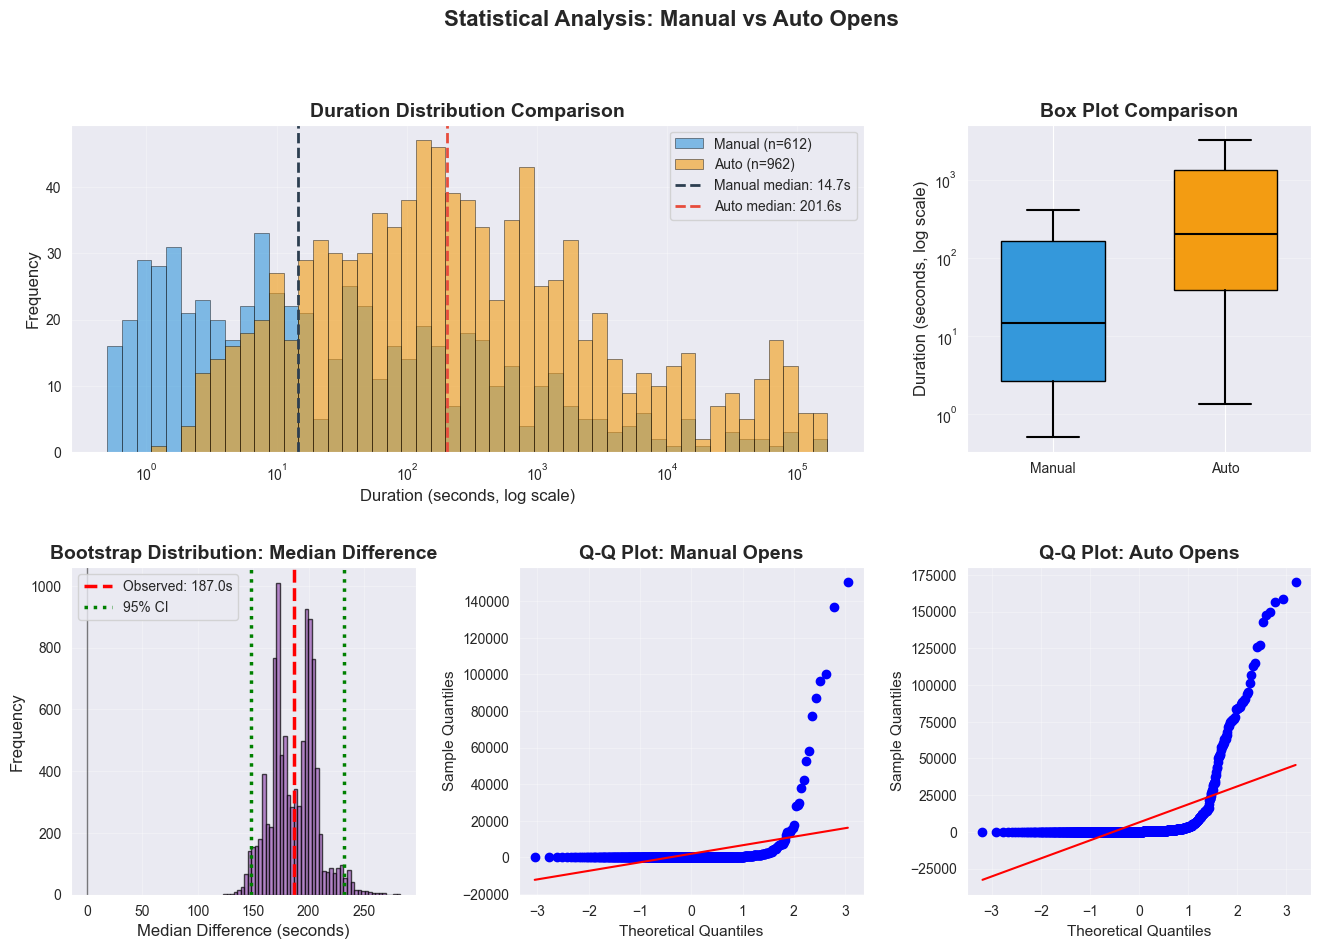

In [367]:
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 3, hspace=0.35, wspace=0.3)

# 1. Distribution comparison (log scale) - SPANS 2 COLUMNS
ax1 = fig.add_subplot(gs[0, :2])
bins = np.logspace(np.log10(0.5), np.log10(sessions_clean['duration_sec'].max()), 50)
ax1.hist(manual_sessions['duration_sec'], bins=bins, alpha=0.6, label=f'Manual (n={len(manual_sessions):,})',
         color='#3498db', edgecolor='black', linewidth=0.5)
ax1.hist(auto_sessions['duration_sec'], bins=bins, alpha=0.6, label=f'Auto (n={len(auto_sessions):,})',
         color='#f39c12', edgecolor='black', linewidth=0.5)
ax1.axvline(manual_stats['median'], color='#2c3e50', linestyle='--', linewidth=2,
            label=f'Manual median: {manual_stats["median"]:.1f}s')
ax1.axvline(auto_stats['median'], color='#e74c3c', linestyle='--', linewidth=2,
            label=f'Auto median: {auto_stats["median"]:.1f}s')
ax1.set_xscale('log')
ax1.set_xlabel('Duration (seconds, log scale)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Duration Distribution Comparison', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Box plot comparison
ax2 = fig.add_subplot(gs[0, 2])
box_data = [manual_sessions['duration_sec'], auto_sessions['duration_sec']]
bp = ax2.boxplot(box_data, labels=['Manual', 'Auto'], patch_artist=True,
                 widths=0.6, showfliers=False)
bp['boxes'][0].set_facecolor('#3498db')
bp['boxes'][1].set_facecolor('#f39c12')
for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp[element], color='black', linewidth=1.5)
ax2.set_ylabel('Duration (seconds, log scale)', fontsize=12)
ax2.set_yscale('log')
ax2.set_title('Box Plot Comparison', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# 3. Bootstrap distribution (median difference)
ax3 = fig.add_subplot(gs[1, 0])
ax3.hist(bootstrap_diffs_median, bins=50, color='#9b59b6', alpha=0.7, edgecolor='black')
ax3.axvline(median_diff_observed, color='red', linestyle='--', linewidth=2.5,
            label=f'Observed: {median_diff_observed:.1f}s')
ax3.axvline(median_ci_lower, color='green', linestyle=':', linewidth=2.5, label='95% CI')
ax3.axvline(median_ci_upper, color='green', linestyle=':', linewidth=2.5)
ax3.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax3.set_xlabel('Median Difference (seconds)', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Bootstrap Distribution: Median Difference', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# 4. Q-Q plot for Manual Opens
ax4 = fig.add_subplot(gs[1, 1])
stats.probplot(manual_sessions['duration_sec'], dist="norm", plot=ax4)
ax4.set_title('Q-Q Plot: Manual Opens', fontsize=14, fontweight='bold')
ax4.set_xlabel('Theoretical Quantiles', fontsize=11)
ax4.set_ylabel('Sample Quantiles', fontsize=11)
ax4.grid(True, alpha=0.3)

# 5. Q-Q plot for Auto Opens
ax5 = fig.add_subplot(gs[1, 2])
stats.probplot(auto_sessions['duration_sec'], dist="norm", plot=ax5)
ax5.set_title('Q-Q Plot: Auto Opens', fontsize=14, fontweight='bold')
ax5.set_xlabel('Theoretical Quantiles', fontsize=11)
ax5.set_ylabel('Sample Quantiles', fontsize=11)
ax5.grid(True, alpha=0.3)

plt.suptitle('Statistical Analysis: Manual vs Auto Opens', fontsize=16, fontweight='bold', y=0.995)
plt.savefig('phase3_statistical_analysis.png', dpi=300, bbox_inches='tight')
print("Visualization saved as 'phase3_statistical_analysis.png'")
print()

### 3.7. Results

In [368]:
print("RESEARCH QUESTION:")
print("  'Do tool windows stay open longer when opened manually vs automatically?'")
print()

print("ANSWER:")
if p_value_mw < 0.05:
    direction = "LONGER" if median_diff_observed > 0 else "SHORTER"
    print(f"    YES - Auto-opened tool windows stay open SIGNIFICANTLY {direction}")
    print(f"    than manually-opened windows")
    print()
    print(f"  Statistical Evidence:")
    print(f"    • Median difference: {abs(median_diff_observed):,.1f} seconds ({median_ratio:.1f}x)")
    print(f"    • Mann-Whitney U test: p = {p_value_mw:.4e} (highly significant)")
    print(f"    • Effect size: {effect_interpretation} (r = {abs(rank_biserial):.3f})")
    print(f"    • 95% CI: [{median_ci_lower:,.1f}, {median_ci_upper:,.1f}] seconds")
else:
    print(f"    NO - No statistically significant difference found")
    print(f"    Mann-Whitney U test: p = {p_value_mw:.4f} (not significant)")

print()

# Export results
results_summary = {
    'test': ['Mann-Whitney U', 'Welch t-test', 'Bootstrap Median CI'],
    'statistic': [f'{u_statistic:,.0f}', f'{t_statistic:.4f}', f'[{median_ci_lower:.1f}, {median_ci_upper:.1f}]'],
    'p_value': [f'{p_value_mw:.4e}', f'{p_value_t:.4e}', 'N/A'],
    'significant': [p_value_mw < 0.05, p_value_t < 0.05, median_ci_lower > 0 or median_ci_upper < 0],
    'effect_size': [f'{abs(rank_biserial):.3f} ({effect_interpretation})',
                    f'{abs(cohens_d):.3f} ({effect_interpretation_d})', 'N/A']
}
results_df = pd.DataFrame(results_summary)
results_df.to_csv('statistical_test_results.csv', index=False)
print(" Results exported to 'statistical_test_results.csv'")
print()


RESEARCH QUESTION:
  'Do tool windows stay open longer when opened manually vs automatically?'

ANSWER:
    YES - Auto-opened tool windows stay open SIGNIFICANTLY LONGER
    than manually-opened windows

  Statistical Evidence:
    • Median difference: 187.0 seconds (13.8x)
    • Mann-Whitney U test: p = 3.6990e-55 (highly significant)
    • Effect size: medium (r = 0.467)
    • 95% CI: [148.4, 232.2] seconds

 Results exported to 'statistical_test_results.csv'



# 4. Sensitivity analysis

### 4.1. Loading datasets

In [369]:
datasets = {}
dataset_names = ['sessions_all', 'sessions_complete', 'sessions_clean', 'sessions_no_outliers']

for name in dataset_names:
    try:
        datasets[name] = pd.read_csv(f'{name}.csv')
        print(f" Loaded {name}.csv: {len(datasets[name]):,} sessions")
    except FileNotFoundError:
        print(f" Warning: {name}.csv not found, skipping...")

print()


 Loaded sessions_all.csv: 1,656 sessions
 Loaded sessions_complete.csv: 1,622 sessions
 Loaded sessions_clean.csv: 1,574 sessions
 Loaded sessions_no_outliers.csv: 1,583 sessions



### 4.2. Testing results across all datasets

In [370]:
sensitivity_results = []

for name, df in datasets.items():
    if len(df) == 0:
        continue

    print(f"\n{name}:")
    # Separate by type
    manual = df[df['open_type'] == 'manual']['duration_sec']
    auto = df[df['open_type'] == 'auto']['duration_sec']

    # Descriptive stats
    manual_median = manual.median()
    auto_median = auto.median()
    median_diff = auto_median - manual_median
    ratio = auto_median / manual_median if manual_median > 0 else np.inf

    # Mann-Whitney test
    u_stat, p_value = mannwhitneyu(manual, auto, alternative='two-sided')

    # Effect size
    n1, n2 = len(manual), len(auto)
    rank_biserial = 1 - (2*u_stat) / (n1 * n2)

    print(f"  Sample sizes: Manual={n1:,}, Auto={n2:,}")
    print(f"  Median durations: Manual={manual_median:.1f}s, Auto={auto_median:.1f}s")
    print(f"  Difference: {median_diff:.1f}s ({ratio:.1f}x)")
    print(f"  Mann-Whitney p-value: {p_value:.4e}")
    print(f"  Effect size (r): {rank_biserial:.3f}")

    if p_value < 0.05:
        print(f"  SIGNIFICANT at α=0.05")
    else:
        print(f"  NOT SIGNIFICANT at α=0.05")

    # Store results
    sensitivity_results.append({
        'dataset': name,
        'n_manual': n1,
        'n_auto': n2,
        'manual_median': manual_median,
        'auto_median': auto_median,
        'median_diff': median_diff,
        'ratio': ratio,
        'p_value': p_value,
        'effect_size': rank_biserial,
        'significant': p_value < 0.05
    })

# Convert to DataFrame
sensitivity_df = pd.DataFrame(sensitivity_results)
print()



sessions_all:
  Sample sizes: Manual=647, Auto=1,009
  Median durations: Manual=14.8s, Auto=223.9s
  Difference: 209.2s (15.2x)
  Mann-Whitney p-value: 2.5964e-55
  Effect size (r): 0.456
  SIGNIFICANT at α=0.05

sessions_complete:
  Sample sizes: Manual=634, Auto=988
  Median durations: Manual=14.0s, Auto=216.7s
  Difference: 202.6s (15.5x)
  Mann-Whitney p-value: 2.2306e-58
  Effect size (r): 0.473
  SIGNIFICANT at α=0.05

sessions_clean:
  Sample sizes: Manual=612, Auto=962
  Median durations: Manual=14.7s, Auto=201.6s
  Difference: 187.0s (13.8x)
  Mann-Whitney p-value: 3.6990e-55
  Effect size (r): 0.467
  SIGNIFICANT at α=0.05

sessions_no_outliers:
  Sample sizes: Manual=616, Auto=967
  Median durations: Manual=14.8s, Auto=209.5s
  Difference: 194.8s (14.2x)
  Mann-Whitney p-value: 4.2885e-54
  Effect size (r): 0.461
  SIGNIFICANT at α=0.05



### 4.3. Robustness assessment

In [371]:
# Check consistency
all_significant = sensitivity_df['significant'].all()
effect_sizes = sensitivity_df['effect_size'].values
effect_size_range = effect_sizes.max() - effect_sizes.min()
median_ratios = sensitivity_df['ratio'].values

print(f"All datasets show significant difference: {all_significant}")
print(f"Effect size range: {effect_sizes.min():.3f} to {effect_sizes.max():.3f} (spread: {effect_size_range:.3f})")
print(f"Median ratio range: {median_ratios.min():.1f}x to {median_ratios.max():.1f}x")
print()

if all_significant and effect_size_range < 0.15:
    print(" FINDING IS ROBUST")
    print("   Result holds consistently across all datasets")
    print("   Effect sizes are stable")
    print("   High confidence in conclusion")
    robustness = "ROBUST"
elif all_significant:
    print(" FINDING IS GENERALLY ROBUST")
    print("   Result significant across datasets")
    print("   Some variation in effect size magnitude")
    print("   Moderate confidence in conclusion")
    robustness = "GENERALLY ROBUST"
else:
    print(" FINDING SHOWS SOME SENSITIVITY")
    print("   Result depends on dataset selection")
    print("   Effect varies with data cleaning choices")
    print("   Interpret with caution")
    robustness = "SENSITIVE"



All datasets show significant difference: True
Effect size range: 0.456 to 0.473 (spread: 0.018)
Median ratio range: 13.8x to 15.5x

 FINDING IS ROBUST
   Result holds consistently across all datasets
   Effect sizes are stable
   High confidence in conclusion


### 4.4. Visualization

Sensitivity visualization saved as 'phase4_sensitivity_analysis.png'



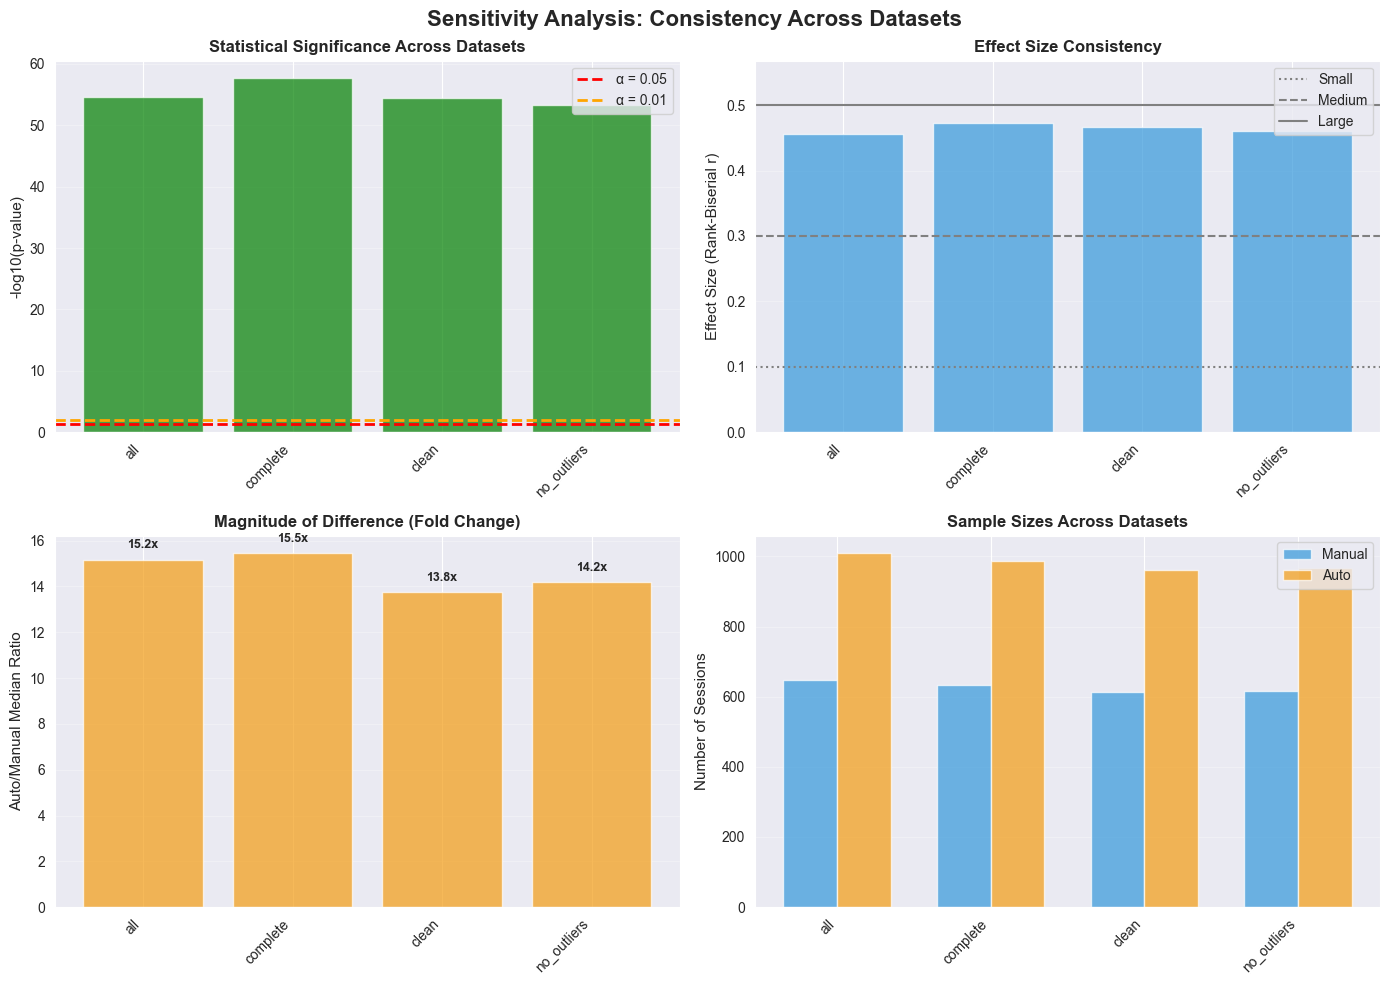

In [372]:
if len(sensitivity_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Sensitivity Analysis: Consistency Across Datasets', fontsize=16, fontweight='bold')

    # 1. P-values across datasets
    ax1 = axes[0, 0]
    colors = ['green' if sig else 'red' for sig in sensitivity_df['significant']]
    ax1.bar(range(len(sensitivity_df)), -np.log10(sensitivity_df['p_value']), color=colors, alpha=0.7)
    ax1.axhline(-np.log10(0.05), color='red', linestyle='--', label='α = 0.05', linewidth=2)
    ax1.axhline(-np.log10(0.01), color='orange', linestyle='--', label='α = 0.01', linewidth=2)
    ax1.set_xticks(range(len(sensitivity_df)))
    ax1.set_xticklabels(sensitivity_df['dataset'].str.replace('sessions_', ''), rotation=45, ha='right')
    ax1.set_ylabel('-log10(p-value)', fontsize=11)
    ax1.set_title('Statistical Significance Across Datasets', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')

    # 2. Effect sizes
    ax2 = axes[0, 1]
    ax2.bar(range(len(sensitivity_df)), sensitivity_df['effect_size'], color='#3498db', alpha=0.7)
    ax2.axhline(0.1, color='gray', linestyle=':', label='Small', linewidth=1.5)
    ax2.axhline(0.3, color='gray', linestyle='--', label='Medium', linewidth=1.5)
    ax2.axhline(0.5, color='gray', linestyle='-', label='Large', linewidth=1.5)
    ax2.set_xticks(range(len(sensitivity_df)))
    ax2.set_xticklabels(sensitivity_df['dataset'].str.replace('sessions_', ''), rotation=45, ha='right')
    ax2.set_ylabel('Effect Size (Rank-Biserial r)', fontsize=11)
    ax2.set_title('Effect Size Consistency', fontsize=12, fontweight='bold')
    ax2.set_ylim(0, max(sensitivity_df['effect_size']) * 1.2)
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')

    # 3. Median ratios
    ax3 = axes[1, 0]
    ax3.bar(range(len(sensitivity_df)), sensitivity_df['ratio'], color='#f39c12', alpha=0.7)
    ax3.set_xticks(range(len(sensitivity_df)))
    ax3.set_xticklabels(sensitivity_df['dataset'].str.replace('sessions_', ''), rotation=45, ha='right')
    ax3.set_ylabel('Auto/Manual Median Ratio', fontsize=11)
    ax3.set_title('Magnitude of Difference (Fold Change)', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    for i, ratio in enumerate(sensitivity_df['ratio']):
        ax3.text(i, ratio + 0.5, f'{ratio:.1f}x', ha='center', fontsize=9, fontweight='bold')

    # 4. Sample sizes
    ax4 = axes[1, 1]
    x = np.arange(len(sensitivity_df))
    width = 0.35
    ax4.bar(x - width/2, sensitivity_df['n_manual'], width, label='Manual', color='#3498db', alpha=0.7)
    ax4.bar(x + width/2, sensitivity_df['n_auto'], width, label='Auto', color='#f39c12', alpha=0.7)
    ax4.set_xticks(x)
    ax4.set_xticklabels(sensitivity_df['dataset'].str.replace('sessions_', ''), rotation=45, ha='right')
    ax4.set_ylabel('Number of Sessions', fontsize=11)
    ax4.set_title('Sample Sizes Across Datasets', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('phase4_sensitivity_analysis.png', dpi=300, bbox_inches='tight')
    print("Sensitivity visualization saved as 'phase4_sensitivity_analysis.png'")
    print()

### 4.5. Summary

In [373]:
print("Detailed comparison across datasets:")
print()
print(sensitivity_df.to_string(index=False))
print()

print("SENSITIVITY ANALYSIS RESULTS:")
print()
print(f"  Datasets tested: {len(sensitivity_df)}")
print(f"  All significant: {all_significant}")
print(f"  Robustness: {robustness}")
print()

print("CONCLUSION:")
if robustness in ["ROBUST", "GENERALLY ROBUST"]:
    print("   Phase 3 finding is CONFIRMED across multiple datasets")
    print("   Auto-opened windows consistently stay open longer")
    print("   Effect is stable regardless of data cleaning choices")
    print("   HIGH CONFIDENCE in the conclusion")

Detailed comparison across datasets:

             dataset  n_manual  n_auto  manual_median  auto_median  median_diff     ratio      p_value  effect_size  significant
        sessions_all       647    1009        14.7600     223.9150     209.1550 15.170393 2.596444e-55     0.455673         True
   sessions_complete       634     988        14.0210     216.6655     202.6445 15.452928 2.230556e-58     0.473398         True
      sessions_clean       612     962        14.6540     201.6220     186.9680 13.758837 3.698961e-55     0.467135         True
sessions_no_outliers       616     967        14.7595     209.5450     194.7855 14.197297 4.288450e-54     0.461068         True

SENSITIVITY ANALYSIS RESULTS:

  Datasets tested: 4
  All significant: True
  Robustness: ROBUST

CONCLUSION:
   Phase 3 finding is CONFIRMED across multiple datasets
   Auto-opened windows consistently stay open longer
   Effect is stable regardless of data cleaning choices
   HIGH CONFIDENCE in the conclusion
